In [ ]:
%matplotlib inline


# Sıfırdan NLP: İsimleri Karakter Düzeyinde RNN ile Sınıflandırma

Bu bölümde kelimeleri sınıflandırmak için temel karakter düzeyinde bir RNN oluşturacak ve eğiteceğiz. 
`torchtext`i kullanarak "sıfırdan" ön işleme, özellikleri kullanma vs. gibi en basic işlemleri sağlayacağız.

Karakter düzeyinde bir RNN, kelimeleri bir dizi karakter olarak okur -
her adımda bir karakter tahmini üretir.
::

    $ python predict.py Hinton
    (-0.47) Scottish
    (-1.52) English
    (-3.57) Irish

    $ python predict.py Schmidhuber
    (-0.19) German
    (-2.48) Czech
    (-2.68) Dutch


**Önerilen Kaynaklar:**

I assume you have at least installed PyTorch, know Python, and
understand Tensors:

-  https://pytorch.org/ eğer google colab kullanmıyorsanız pytorch kurulumu için siteyi kontrol edebilirsiniz.

-  `/beginner/deep_learning_60min_blitz` genel olarak PyTorch'a başlamak için
-  `/beginner/pytorch_with_examples` geniş ve derin bir genel bakış için
-  `/beginner/former_torchies_tutorial` eski Lua Torch kullanıcısıysanız

RNN'ler ve nasıl çalıştıkları hakkında bilgi sahibi olmak içinse aşağıdaki kaynaklar yararlı olacaktır:

-  [The Unreasonable Effectiveness of Recurrent Neural
   Networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/)
   
-  [Understanding LSTM
   Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)

## Verilerin Hazırlanması

..Not::
   Verileri şu adresten indirin:
   [adres](https://download.pytorch.org/tutorial/data.zip)
  ve geçerli dizine çıkartın.

``data/names`` dizininde şu şekilde adlandırılan 18 metin dosyası bulunur:
"[Language].txt". Her dosyada bir ad olmak üzere bir grup ad içerir.
Satır, çoğunlukla romanlaştırılmış (ancak yine de Unicode'dan Unicode'a dönüştürmemiz gerekiyor).

Her dil için bir isim listesi sözlüğü elde edeceğiz,
``{language: [names ...]}``. Genel değişkenler "kategori" ve "satır"
(bizim durumumuzda dil ve isim için) daha sonra genişletilebilirlik için kullanılır.


In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Bir Unicode dizesini düz ASCII'ye çevirin, teşekkürler :) ---> https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Her dil için bir ad listesi olan Category_lines sözlüğünü oluşturun
category_lines = {}
all_categories = []

# Bir dosyayı okuyun ve satırlara bölün
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Chinese.txt', 'data/names/Scottish.txt', 'data/names/Irish.txt', 'data/names/Arabic.txt', 'data/names/Greek.txt', 'data/names/Czech.txt', 'data/names/French.txt', 'data/names/English.txt', 'data/names/Japanese.txt', 'data/names/Polish.txt', 'data/names/Russian.txt', 'data/names/Portuguese.txt', 'data/names/Dutch.txt', 'data/names/German.txt', 'data/names/Vietnamese.txt', 'data/names/Spanish.txt', 'data/names/Italian.txt', 'data/names/Korean.txt']
Slusarski


Şimdi, her kategoriyi (dili) satırlar (adlar) listesine eşleyen bir sözlük olan Category_lines'a sahibiz. Ayrıca all_categories (yalnızca bir dil listesi) ve n_categories'i daha sonra başvurmak üzere takip ettik.



In [2]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


### İsimleri Tensörlere Dönüştürmek

Artık tüm isimleri organize ettiğimize göre, onları tensörlere dönüştürmemiz gerekiyor. Biliyorsunuz ki bu işler sayısal veri tipleri ile yapılır.


Tek bir harfi temsil etmek için, boyutta bir "tek sıcak vektör" kullanırız.
``<1 x n_letters>``. Bir sıcak vektör, 1 dışında 0'larla doldurulur.
geçerli harfin dizininde, örneğin: ``"b" = <0 1 0 0 0 ...>``.

Bir kelime yapmak için bunlardan bir demetini 2B matriste birleştiriyoruz.
``<line_length x 1 x n_letters>``.

Bu ekstra 1 boyutun nedeni, PyTorch'un her şeyin içinde olduğunu varsaymasıdır.
batches  - burada sadece 1 parti boyutunu kullanıyoruz.



In [3]:
import torch

# all_letters'tan harf indeksini bulun, örneğin: "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

#  <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

#  <line_length x 1 x n_letters>,
#  one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


## Ağı Oluşturalım


In [4]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

Bu ağın bir adımını çalıştırmak için bir girişi (bizim durumumuzda, geçerli harf için Tensör) ve önceki bir gizli durumu (ilk başta sıfır olarak başlattığımız) geçirmemiz gerekir. Çıktıyı (her dilin olasılığı) ve bir sonraki gizli durumu (bir sonraki adım için saklıyoruz) geri alacağız.



In [6]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

Verimlilik adına her adım için yeni bir Tensör oluşturmak istemiyoruz, bu nedenle `letterToTensor` yerine `lineToTensor` kullanacağız ve dilimler kullanacağız. Bu, Tensör gruplarının önceden hesaplanmasıyla daha da optimize edilebilir.




In [7]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9635, -2.9190, -2.8588, -2.8515, -2.8718, -2.8580, -2.8457, -2.7812,
         -2.9625, -2.9836, -2.8698, -2.9475, -2.9710, -2.8928, -2.8519, -2.8365,
         -2.9297, -2.8594]], grad_fn=<LogSoftmaxBackward0>)


Gördüğünüz gibi çıktı bir <1 x n_categories> Tensörüdür, burada her öğe o kategorinin olasılığıdır.




## Eğitim
Eğitime Hazırlanmak
----------------------

Eğitime geçmeden önce birkaç yardımcı fonksiyon yapmalıyız.
Örneğin çıkan tensörden en büyük değeri alarak hangi kategoriye ait olduğunu bulmak gibi.




In [8]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('English', 7)


Ayrıca bir eğitim örneği almanın hızlı bir yolununu yapalım.

In [9]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Korean / line = Baik
category = Korean / line = Han
category = Dutch / line = Peter
category = Scottish / line = Jones
category = Spanish / line = Ruiz
category = Czech / line = Rzehak
category = Arabic / line = Hakimi
category = Spanish / line = Varela
category = Vietnamese / line = Luc
category = Polish / line = Starek


### Ağı Eğitelim

Şimdi bu ağı eğitmek için gereken tek şey ona bir dizi örnek göstermek,
tahminlerde bulunmasını sağlayalım, loss'u hesaplayalım. BP ile hatalarımızı geri yayalım ve hata değerinin giriş değerlerine göre türevini hesaplayarak ağırlık ve bias değerlerimizi güncelleyelim. ( Bu kadar uzun ve iki kez aynı şeyi yazdığımın farkındayım :) kısaca BP -BackProb yapacağız. )

Kayıp işlevi için ``nn.NLLLoss`` uygundur, çünkü son
RNN'nin katmanı ``nn.LogSoftmax`` şeklindedir.




In [10]:
criterion = nn.NLLLoss()

Her eğitim döngüsü şunları yapacaktır:

- Giriş ve hedef tensörler oluşturun
- Sıfırlanmış bir ilk gizli durum oluşturun
- Her harfi oku ve

    - Bir sonraki harf için gizli durumu koru

- Nihai çıktıyı hedefle karşılaştırın
- Geri yayılma
- Çıktıyı ve kaybı ağa yayın.



In [12]:
learning_rate = 0.005 # Bunu çok yükseğe ayarlarsanız gradyan patmalası yaşanılabilir.. Çok düşükse, öğrenemeyebilir ya da ağın öğrenmesi çok yavaş olur. Buna da kaybolan gradyan sorunu denir.

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Parametrelerin gradyanlarını öğrenme oranıyla çarparak değerlerine ekleyin, yani ağırlıkları güncelleyelim.
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

Şimdi bunu bir dizi örnekle çalıştırmamız gerekiyor. Train işlevi hem çıktıyı hem de kaybı döndürdüğünden, tahminlerini yazdırabilir ve ayrıca çizim için kaybı takip edebiliriz. 1000'lerce örnek olduğu için sadece her print_every örneğini yazdırıyoruz ve kaybın ortalamasını alıyoruz.



In [13]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Çizim için kayıpları takip edin
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Iter numarasını, kaybı, adı ve tahmini yazdırın
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Kayıplar listesine toplam kayıp ortalamasını ekle
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 7s) 3.2303 Schwartz / French ✗ (German)
10000 10% (0m 13s) 2.5758 Crawford / French ✗ (Scottish)
15000 15% (0m 19s) 1.9490 Rodagh / Irish ✓
20000 20% (0m 26s) 2.8189 Salinas / Greek ✗ (Spanish)
25000 25% (0m 32s) 0.4954 Kojima / Japanese ✓
30000 30% (0m 39s) 2.8771 Buffone / French ✗ (Italian)
35000 35% (0m 44s) 1.3440 Tansley / English ✓
40000 40% (0m 51s) 2.5129 Armistead / Scottish ✗ (French)
45000 45% (0m 57s) 0.4424 Haddad / Arabic ✓
50000 50% (1m 4s) 1.6885 Kolijn / Dutch ✓
55000 55% (1m 10s) 0.1304 Robertson / Scottish ✓
60000 60% (1m 17s) 0.6720 Ramirez / Spanish ✓
65000 65% (1m 23s) 2.1541 Gagne / Irish ✗ (French)
70000 70% (1m 30s) 0.5167 Lian / Chinese ✓
75000 75% (1m 35s) 2.9034 Falk / Czech ✗ (German)
80000 80% (1m 42s) 0.3658 Akechi / Japanese ✓
85000 85% (1m 48s) 0.6547 Ferguson / Scottish ✓
90000 90% (1m 54s) 1.7058 Orbell / English ✓
95000 95% (2m 1s) 0.1680 Abeldyaev / Russian ✓
100000 100% (2m 7s) 0.1447 De la fontaine / French ✓


### Sonuçların Çizilmesi

``all_losses``tan geçmiş kaybın çizilmesi, ağın öğrenme durumunu gösterir.



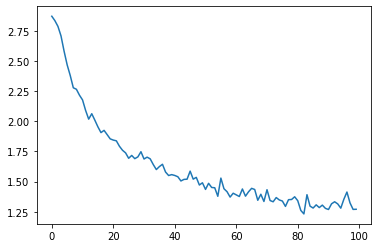

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

## Sonuçların Değerlendirilmesi


<ipython-input-15-a0fe762f1796>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-15-a0fe762f1796>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


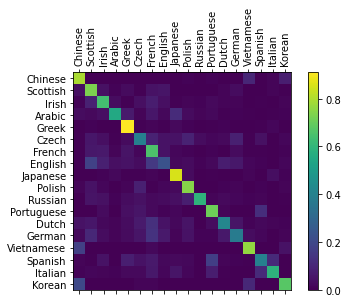

In [15]:
# Bir karışıklık matrisinde doğru tahminleri takip edin
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Sadece bir satır verilen bir çıktı döndürün
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Bir dizi örneği gözden geçirin ve doğru tahmin edilenleri kaydedin
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Her satırı toplamına bölerek normalleştir
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

### Kullanıcıdan alınan bir giriş ile modeli test edelim.




In [16]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.82) Russian
(-0.93) Czech
(-2.34) English

> Jackson
(-0.71) Scottish
(-1.18) English
(-2.50) Dutch

> Satoshi
(-0.61) Japanese
(-2.56) Greek
(-2.65) Italian
